In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
from sklearn import svm
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
#from spellchecker import SpellChecker
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.utils import resample
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from statistics import mean 
import contractions
from sklearn.metrics import classification_report
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\limju\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\limju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load train data

In [98]:
#Read in cleaned train data
train_df = pd.read_csv('train_data.csv')
train_df = train_df.dropna(subset=['cleaned_text']).reset_index(drop=True)
train_df['polarity_score'] = train_df['polarity_score'].astype(float)
train_df['subjectivity_score'] = train_df['subjectivity_score'].astype(float)
train_df['stars'] = train_df['stars'].astype(float)
train_df['text'] = train_df['text'].astype(str)


train_df.head()

,idx,title,stars,text,cleaned_text,subjectivity_score,polarity_score
0,1,88 Seafood,5.0,This was my first time eating here. I can tell...,first time eat tell shd crayfish dish sooooooo...,0.434167,0.330795
1,2,88 Seafood,4.0,Considering that the dining area is next to a ...,consider din area be next prawn fish area migh...,0.385397,0.074921
2,3,88 Seafood,4.0,1st time came was 5 months ago. A decent Cze C...,st time come month ago decent cze char order c...,0.412037,0.186111
3,4,88 Seafood,5.0,"First time experiencing prawning, we spend a g...",first time experience prawn spend good hr praw...,0.528030,0.183333
4,5,88 Seafood,4.0,"Outgoing visit on Saturday, September 2023. Fi...",outgo visit saturday september fish shrimp cho...,0.377778,-0.138889


<Axes: xlabel='stars', ylabel='count'>

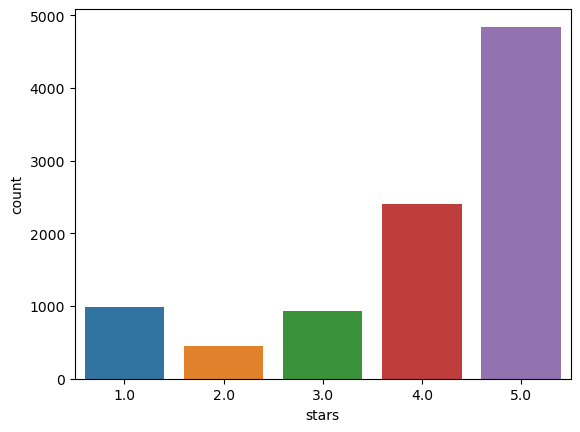

In [99]:
sns.countplot(train_df, x="stars")

### Load test data

In [100]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = set(stopwords.words('english'))
    custom_stopwords = {'not', 'is', 'but'}
    STOPWORDS -= custom_stopwords
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    # Split the reviews into words and remove stopwords
    words = reviews.split()
    words_filtered = [word for word in words if word not in STOPWORDS]
    
    # Join the filtered words back into a string
    filtered_reviews = ' '.join(words_filtered)
    
    return filtered_reviews

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review


def clean_text(data):

    data = data.apply(lower_case)
    data = data.apply(change_contractions)
    data = data.apply(remove_emojis)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_numbers)
    data = data.apply(remove_stopwords)
    data = data.apply(remove_extra_whitespace)
    data = data.apply(lemmaSentence)
    
    return data

def clean_text_withstopword(data):

    data = data.apply(lower_case)
    data = data.apply(change_contractions)
    data = data.apply(remove_emojis)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_numbers)
    #data = data.apply(remove_stopwords)
    data = data.apply(remove_extra_whitespace)
    data = data.apply(lemmaSentence)
    
    return data

In [101]:
testdf = pd.read_csv("test_data.csv")

In [102]:
testdf['cleaned_text'] = clean_text(testdf.text)
def anno2binary(text):
    if text=='POSITIVE':
        return 1
    else:
        return 0
testdf['Binary_anno'] = testdf.Polarity_Anno1.apply(anno2binary)

### Assign polarity to train data
- Stars 4 and above, positive


In [103]:
#assign positive/negative labels method 1
train_df['sentiment'] = 0
train_df.loc[train_df['stars'] >=4, 'sentiment'] = 1 #positive

In [104]:
train_df_X = train_df['cleaned_text']
train_df_y = train_df['sentiment']

In [105]:
# Run this if you want stemmed instead of lemmatized words
def stemSentence(reviews):
    stemmer = PorterStemmer()
    stem_text = ''
    tok_text = word_tokenize(reviews)
    for i in range(len(tok_text)):
        stem_text = stem_text + ' ' + stemmer.stem(tok_text[i])
    return stem_text[1:]

train_df_X = train_df_X.apply(stemSentence)

<Axes: xlabel='sentiment', ylabel='count'>

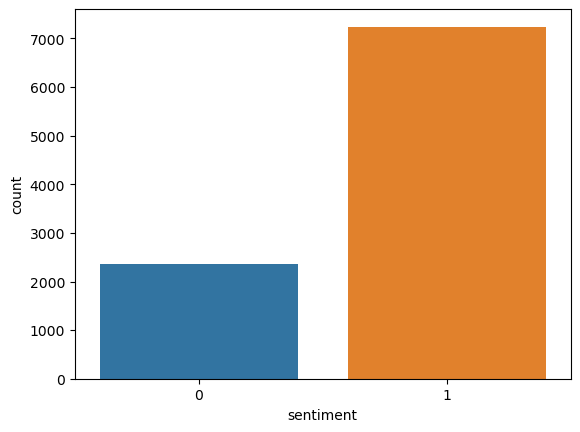

In [106]:
#visualize distribution. We must balance.
sns.countplot(train_df, x="sentiment")

### Classification


In [107]:
def max_key_for_max_value(dictionary):
    if not dictionary:  # If the dictionary is empty
        return None, None

    max_value = max(dictionary.values())  # Find the maximum value in the dictionary
    max_key = None

    for key, value in dictionary.items():
        if value == max_value:
            max_key = key

    return max_key, max_value

# Example usage:
my_dict = {'a': 10, 'b': 20, 'c': 20, 'd': 15}
max_key, max_value = max_key_for_max_value(my_dict)
print("Key with maximum value:", max_key)
print("Maximum value:", max_value)


Key with maximum value: c
Maximum value: 20


### Model 1: TFIDF + SVM

In [108]:
#Find optimal hyperparameters
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'C': [0.5,1, 5, 10], 'kernel': ['rbf'], 'gamma':['scale','auto']}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for param in param_grid:
    param_f1 = []
    for train_index, test_index in kf.split(train_df_X, train_df_y):
        #split into train and val
        X_train, X_test = train_df_X[train_index],train_df_X[test_index]
        y_train, y_test = train_df_y[train_index], train_df_y[test_index]

        #Fit TFIDF vectorize on train first, then undersample
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
        tfidf_vectorizer.fit(X_train)


        #Split into majority and minority for undersampling here
        X_train_majority_class = X_train[y_train == 1]
        y_train_majority_class = y_train[y_train == 1]
        X_train_minority_class = X_train[y_train == 0]
        y_train_minority_class = y_train[y_train == 0]

        # Downsample majority class only
        X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(X_train_minority_class),   # to match minority class
                                        random_state=42)  # reproducible results

        # Combine minority class with downsampled majority class
        X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
        y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


        X_train_vector = tfidf_vectorizer.transform(X_train_balanced)
        X_test_vector = tfidf_vectorizer.transform(X_test)

        svc = svm.SVC(**param)
        svc.fit(X_train_vector, y_train_balanced)
        
        y_pred = svc.predict(X_test_vector)

        f1 = f1_score(y_test, y_pred, average='macro')
        param_f1.append(f1)
        #print("Macro F1 Score:", f1)
    param_str = str(param)
    print(param)
    f1_scores[param_str] = mean(param_f1)



{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}


KeyboardInterrupt: 

In [ ]:
max_key_for_max_value(f1_scores)

("{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}", 0.8351423381221252)

In [ ]:
# Fit optimal hyperparameters on entire train data
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
tfidf_vectorizer.fit(train_df_X)


#Split into majority and minority for undersampling here
X_train_majority_class = train_df_X[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_df_X[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


X_train_vector = tfidf_vectorizer.transform(X_train_balanced)

svc = svm.SVC(C= 1, gamma= 'scale', kernel= 'rbf') #Optimal hyperparameters here
svc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text)
y_test_pred = svc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 1.2766022682189941s


In [ ]:
1068/(end-start)

836.5957249081046

In [ ]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75       220
           1       0.98      0.85      0.91       848

    accuracy                           0.87      1068
   macro avg       0.80      0.89      0.83      1068
weighted avg       0.91      0.87      0.88      1068



### Model 2: TFIDF + Random Forest

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'n_estimators': [100,200,250], 'max_depth':[5,10,20,None],'ccp_alpha':[0], 'max_features':['sqrt'],'n_jobs':[-1]}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for param in param_grid:
    param_f1 = []
    for train_index, test_index in kf.split(train_df_X, train_df_y):
        #split into train and val
        X_train, X_test = train_df_X[train_index],train_df_X[test_index]
        y_train, y_test = train_df_y[train_index], train_df_y[test_index]

        #Fit TFIDF vectorize on train first, then undersample
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
        tfidf_vectorizer.fit(X_train)


        #Split into majority and minority for undersampling here
        X_train_majority_class = X_train[y_train == 1]
        y_train_majority_class = y_train[y_train == 1]
        X_train_minority_class = X_train[y_train == 0]
        y_train_minority_class = y_train[y_train == 0]

        # Downsample majority class only
        X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(X_train_minority_class),   # to match minority class
                                        random_state=42)  # reproducible results

        # Combine minority class with downsampled majority class
        X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
        y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


        X_train_vector = tfidf_vectorizer.transform(X_train_balanced)
        X_test_vector = tfidf_vectorizer.transform(X_test)

        rfc = RandomForestClassifier(**param)
        #rfc = RandomForestClassifier()

        rfc.fit(X_train_vector, y_train_balanced)
        
        y_pred = rfc.predict(X_test_vector)

        f1 = f1_score(y_test, y_pred, average='macro')
        param_f1.append(f1)
        print("Macro F1 Score:", f1)
    
    param_str = str(param)
    print("F1 Score:", param_f1)
    f1_scores[param_str] = mean(param_f1)



Macro F1 Score: 0.8088136927011607
Macro F1 Score: 0.8078305710450226
Macro F1 Score: 0.8139518088087925
Macro F1 Score: 0.8030079718582818
Macro F1 Score: 0.8012140902872777


In [ ]:
max_key_for_max_value(f1_scores)

(None, None)

In [ ]:
# Fit optimal hyperparameters on entire train data
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
tfidf_vectorizer.fit(train_df_X)


#Split into majority and minority for undersampling here
X_train_majority_class = train_df_X[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_df_X[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


X_train_vector = tfidf_vectorizer.transform(X_train_balanced)

rfc = RandomForestClassifier(ccp_alpha= 0, max_depth= None, max_features= 'sqrt', n_estimators= 250, n_jobs= -1, random_state=42) #Optimal hyperparameters here
rfc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text)
y_test_pred = rfc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 0.11025452613830566s


In [ ]:
1068/(end-start)

9686.677158815935

In [ ]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.58      0.93      0.71       220
           1       0.98      0.83      0.90       848

    accuracy                           0.85      1068
   macro avg       0.78      0.88      0.81      1068
weighted avg       0.90      0.85      0.86      1068



### Model 3: TFIDF + Naive Bayes

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'alpha':[1]}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for param in param_grid:
    param_f1 = []
    for train_index, test_index in kf.split(train_df_X, train_df_y):
        #split into train and val
        X_train, X_test = train_df_X[train_index],train_df_X[test_index]
        y_train, y_test = train_df_y[train_index], train_df_y[test_index]

        #Fit TFIDF vectorize on train first, then undersample
        tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,3))
        tfidf_vectorizer.fit(X_train)


        #Split into majority and minority for undersampling here
        X_train_majority_class = X_train[y_train == 1]
        y_train_majority_class = y_train[y_train == 1]
        X_train_minority_class = X_train[y_train == 0]
        y_train_minority_class = y_train[y_train == 0]

        # Downsample majority class only
        X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(X_train_minority_class),   # to match minority class
                                        random_state=42)  # reproducible results

        # Combine minority class with downsampled majority class
        X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
        y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


        X_train_vector = tfidf_vectorizer.transform(X_train_balanced)
        X_test_vector = tfidf_vectorizer.transform(X_test)

        nbc = MultinomialNB(**param)
        nbc.fit(X_train_vector, y_train_balanced)
        
        y_pred = nbc.predict(X_test_vector)

        f1 = f1_score(y_test, y_pred, average='macro')
        param_f1.append(f1)
        #print("Macro F1 Score:", f1)
    param_str = str(param)
    print("F1 Score:", param_f1)
    f1_scores[param_str] = mean(param_f1)



F1 Score: [0.8095733038890933, 0.804821005472856, 0.8296010773411608, 0.8139778684898411, 0.8127726635523194]


In [ ]:
f1_scores

{"{'alpha': 1}": 0.8141491837490541}

In [ ]:
import datetime
# Fit optimal hyperparameters on entire train data
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
tfidf_vectorizer.fit(train_df_X)


#Split into majority and minority for undersampling here
X_train_majority_class = train_df_X[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_df_X[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


X_train_vector = tfidf_vectorizer.transform(X_train_balanced)

nbc = MultinomialNB() #Optimal hyperparameters here
nbc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text)
start= datetime.datetime.now()
for i in range(20):
    X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text)
    y_test_pred = nbc.predict(X_test_vector)

end = datetime.datetime.now()
t = end-start
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {t.total_seconds()}s")

Time taken to predict test set = 1.335941s


In [ ]:
(20*1068) / t.total_seconds()

15988.73004122188

In [ ]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.93      0.70       220
           1       0.98      0.81      0.89       848

    accuracy                           0.84      1068
   macro avg       0.77      0.87      0.79      1068
weighted avg       0.89      0.84      0.85      1068



## Innovation - Stacked ensemble

In [145]:
# Fit optimal hyperparameters on entire train data
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
tfidf_vectorizer.fit(train_df_X)


#Split into majority and minority for undersampling here
X_train_majority_class = train_df_X[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_df_X[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


X_train_vector = tfidf_vectorizer.transform(X_train_balanced)


estimators = [#('nbc', MultinomialNB()), 
              ('rfc', RandomForestClassifier(n_jobs= -1,random_state=42)),
              ('knc', KNeighborsClassifier()),]
              #('svm', svm.SVC(C= 15, gamma= 'scale', kernel= 'rbf'))
              #]

#estimators = [('svm', svm.SVC(C= 1, gamma= 'auto', kernel= 'rbf'))]
stackclf = StackingClassifier(estimators=estimators)


stackclf.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text)
y_test_pred = stackclf.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 0.8282756805419922s


In [143]:
stackclf.estimators_

[MultinomialNB(), KNeighborsClassifier()]

In [150]:
(1068) / (end-start)

1289.425761361412

In [149]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.46      0.93      0.62       220
           1       0.97      0.72      0.83       848

    accuracy                           0.76      1068
   macro avg       0.72      0.83      0.72      1068
weighted avg       0.87      0.76      0.79      1068



## Innovation - Add POS tags to TFIDF

In [ ]:
def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def add_pos_tags_to_lemma(text):
    #appends POS tag to end of each word
    pos_text = ''
    tok_text = word_tokenize(text)
    tags = get_wordnet_pos(tok_text)
    for i, word in enumerate(tok_text):
        pos_text = pos_text + ' ' + f'{tok_text[i]}_{tags[i]}'
    return pos_text

def add_pos_tags_to_stem(text):
    #appends POS tag to end of each word
    stemmer=PorterStemmer()
    pos_text = ''
    tok_text = word_tokenize(text)
    tags = get_wordnet_pos(tok_text)
    for i, word in enumerate(tok_text):
        pos_text = pos_text + ' ' + f'{stemmer.stem(tok_text[i])}_{tags[i]}'
    return pos_text


In [ ]:
#Add POS labels behind each word
train_df_X_POS = train_df_X.apply(add_pos_tags_to_lemma)
#train_df_X_stem_POS = train_df_X.apply(add_pos_tags_to_stem)

In [ ]:
testdf['cleaned_text_POS'] = testdf.cleaned_text.apply(add_pos_tags_to_lemma)

### TFIDF POS + SVM

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'C': [0.5,1, 5, 10,15], 'kernel': ['rbf'], 'gamma':['scale']}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for param in param_grid:
    param_f1 = []
    for train_index, test_index in kf.split(train_df_X_POS, train_df_y):
        #split into train and val
        X_train, X_test = train_df_X_POS[train_index],train_df_X_POS[test_index]
        y_train, y_test = train_df_y[train_index], train_df_y[test_index]

        #Fit TFIDF vectorize on train first, then undersample
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000, ngram_range=(1,3), stop_words=['_a','_n','_r','_v'])
        tfidf_vectorizer.fit(X_train)


        #Split into majority and minority for undersampling here
        X_train_majority_class = X_train[y_train == 1]
        y_train_majority_class = y_train[y_train == 1]
        X_train_minority_class = X_train[y_train == 0]
        y_train_minority_class = y_train[y_train == 0]

        # Downsample majority class only
        X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(X_train_minority_class),   # to match minority class
                                        random_state=42)  # reproducible results

        # Combine minority class with downsampled majority class
        X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
        y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


        X_train_vector = tfidf_vectorizer.transform(X_train_balanced)
        X_test_vector = tfidf_vectorizer.transform(X_test)

        svc = svm.SVC(**param)
        svc.fit(X_train_vector, y_train_balanced)
        
        y_pred = svc.predict(X_test_vector)

        f1 = f1_score(y_test, y_pred, average='macro')
        param_f1.append(f1)
    param_str = str(param)
    print("F1 Score:", param_f1)
    f1_scores[param_str] = mean(param_f1)



F1 Score: [0.8177186905351013, 0.8185271522050939, 0.825887058504041, 0.8189530791461783, 0.8053814002089863]
F1 Score: [0.8218483598273628, 0.8285821100745483, 0.8357168473613066, 0.8262399596282435, 0.8171117272240868]
F1 Score: [0.8261709913201911, 0.8249493594924319, 0.8359864649986066, 0.8255868344091795, 0.8239411242228143]
F1 Score: [0.8261709913201911, 0.8249493594924319, 0.8359864649986066, 0.8255868344091795, 0.8239411242228143]
F1 Score: [0.8261709913201911, 0.8249493594924319, 0.8359864649986066, 0.8255868344091795, 0.8239411242228143]


In [ ]:
max_key_for_max_value(f1_scores)

("{'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}", 0.8273269548886447)

In [ ]:
# Fit optimal hyperparameters on entire train data
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
tfidf_vectorizer.fit(train_df_X_POS)


#Split into majority and minority for undersampling here
X_train_majority_class = train_df_X_POS[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_df_X_POS[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


X_train_vector = tfidf_vectorizer.transform(X_train_balanced)

svc = svm.SVC(C= 20, gamma= 'scale', kernel= 'rbf')
svc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text_POS)
y_test_pred = svc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 1.1655681133270264s


In [ ]:
1068/(end-start)

916.2913670926313

In [ ]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.60      0.92      0.73       220
           1       0.98      0.84      0.90       848

    accuracy                           0.86      1068
   macro avg       0.79      0.88      0.82      1068
weighted avg       0.90      0.86      0.87      1068



### TFIDF POS + Random Forest

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'n_estimators': [100,200,250], 'max_depth':[5,10,20,None],'ccp_alpha':[0], 'max_features':['sqrt'],'n_jobs':[-1]}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for param in param_grid:
    param_f1 = []
    for train_index, test_index in kf.split(train_df_X_POS, train_df_y):
        #split into train and val
        X_train, X_test = train_df_X_POS[train_index],train_df_X_POS[test_index]
        y_train, y_test = train_df_y[train_index], train_df_y[test_index]

        #Fit TFIDF vectorize on train first, then undersample
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000, ngram_range=(1,3), stop_words=['_a','_n','_r','_v'])
        tfidf_vectorizer.fit(X_train)


        #Split into majority and minority for undersampling here
        X_train_majority_class = X_train[y_train == 1]
        y_train_majority_class = y_train[y_train == 1]
        X_train_minority_class = X_train[y_train == 0]
        y_train_minority_class = y_train[y_train == 0]

        # Downsample majority class only
        X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(X_train_minority_class),   # to match minority class
                                        random_state=42)  # reproducible results

        # Combine minority class with downsampled majority class
        X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
        y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


        X_train_vector = tfidf_vectorizer.transform(X_train_balanced)
        X_test_vector = tfidf_vectorizer.transform(X_test)

        rfc = RandomForestClassifier(**param)
        rfc.fit(X_train_vector, y_train_balanced)
        
        y_pred = rfc.predict(X_test_vector)

        f1 = f1_score(y_test, y_pred, average='macro')
        param_f1.append(f1)
    param_str = str(param)
    print("F1 Score:", param_f1)
    f1_scores[param_str] = mean(param_f1)



F1 Score: [0.7978159600936621, 0.7841882219636284, 0.7837597216537044, 0.7645321938666224, 0.782531476236497]
F1 Score: [0.7878477165075104, 0.7959343617470864, 0.8031369074175481, 0.7794964087098919, 0.7658251006220271]
F1 Score: [0.7903430367122668, 0.7804949923421727, 0.8011274135663131, 0.7755218360018017, 0.7750068965883548]
F1 Score: [0.7920286677817654, 0.7856194690265487, 0.7954996158715102, 0.7806606625009866, 0.7614919507519142]
F1 Score: [0.7986905410312274, 0.800250872657776, 0.798890284757119, 0.7768238227779718, 0.7731709731709732]
F1 Score: [0.7927986596810487, 0.7987726302474505, 0.7981615848075578, 0.789671682626539, 0.7861911770890282]
F1 Score: [0.8069958597995981, 0.8039436591806504, 0.8104457396824024, 0.779270684123452, 0.779270684123452]
F1 Score: [0.8031914185886229, 0.7963651245455832, 0.8131238623428592, 0.7995360813772849, 0.7969824008852759]
F1 Score: [0.803160411476332, 0.8065316511325558, 0.8130314486010165, 0.808161106174714, 0.779270684123452]
F1 Score: 

In [ ]:
max_key_for_max_value(f1_scores)

("{'ccp_alpha': 0, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 250, 'n_jobs': -1}",
 0.8020310603016141)

In [ ]:
# Fit optimal hyperparameters on entire train data
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
tfidf_vectorizer.fit(train_df_X_POS)


#Split into majority and minority for undersampling here
X_train_majority_class = train_df_X_POS[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_df_X_POS[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


X_train_vector = tfidf_vectorizer.transform(X_train_balanced)

rfc = RandomForestClassifier(ccp_alpha= 0, max_depth= 20, max_features= 'sqrt', n_estimators= 250, n_jobs= -1)
rfc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text_POS)
y_test_pred = rfc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 0.10002303123474121s


In [ ]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.59      0.92      0.72       220
           1       0.98      0.83      0.90       848

    accuracy                           0.85      1068
   macro avg       0.78      0.88      0.81      1068
weighted avg       0.90      0.85      0.86      1068



### TFIDF POS + Naive Bayes

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'alpha':[1]}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for param in param_grid:
    param_f1 = []
    for train_index, test_index in kf.split(train_df_X_POS, train_df_y):
        #split into train and val
        X_train, X_test = train_df_X_POS[train_index],train_df_X_POS[test_index]
        y_train, y_test = train_df_y[train_index], train_df_y[test_index]

        #Fit TFIDF vectorize on train first, then undersample
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000, ngram_range=(1,3), stop_words=['_a','_n','_r','_v'])
        tfidf_vectorizer.fit(X_train)


        #Split into majority and minority for undersampling here
        X_train_majority_class = X_train[y_train == 1]
        y_train_majority_class = y_train[y_train == 1]
        X_train_minority_class = X_train[y_train == 0]
        y_train_minority_class = y_train[y_train == 0]

        # Downsample majority class only
        X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(X_train_minority_class),   # to match minority class
                                        random_state=42)  # reproducible results

        # Combine minority class with downsampled majority class
        X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
        y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


        X_train_vector = tfidf_vectorizer.transform(X_train_balanced)
        X_test_vector = tfidf_vectorizer.transform(X_test)

        nbc = MultinomialNB(**param)
        nbc.fit(X_train_vector, y_train_balanced)
        
        y_pred = nbc.predict(X_test_vector)

        f1 = f1_score(y_test, y_pred, average='macro')
        param_f1.append(f1)
    param_str = str(param)
    print("F1 Score:", param_f1)
    f1_scores[param_str] = mean(param_f1)



F1 Score: [0.798231045449683, 0.8032970910314013, 0.8233272196991352, 0.8069573824451869, 0.8034802955569289]


In [ ]:
max_key_for_max_value(f1_scores)

("{'alpha': 1}", 0.8070586068364671)

In [ ]:
# Fit optimal hyperparameters on entire train data
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=20000,ngram_range=(1,3))
tfidf_vectorizer.fit(train_df_X_POS)


#Split into majority and minority for undersampling here
X_train_majority_class = train_df_X_POS[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_df_X_POS[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


X_train_vector = tfidf_vectorizer.transform(X_train_balanced)

nbc = MultinomialNB()
nbc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = tfidf_vectorizer.transform(testdf.cleaned_text_POS)
y_test_pred = nbc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 0.07051753997802734s


In [ ]:
1068/(end-start)

15145.16814302909

In [ ]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.94      0.70       220
           1       0.98      0.81      0.88       848

    accuracy                           0.83      1068
   macro avg       0.77      0.87      0.79      1068
weighted avg       0.89      0.83      0.85      1068

